In [1]:
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pydiffmap import diffusion_map as dm
from scaccordion import tl
import networkx as nx
from sklearn.preprocessing import Normalizer
import warnings
import ot
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from sklearn import manifold
from scipy.linalg import  norm
import phate
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
import sci_palettes
from tqdm import tqdm
import random


warnings.filterwarnings("ignore")

class KBary2:
    def __init__(self,k=3, max_iters=100,init='random',random_state=42,mode='min'):
        self.k = k
        self.max_iters = max_iters
        self.flabels = None
        self.bary = []
        self.centroids = None
        self.err = []
        self.mode = mode
    
    def fit(self, data, distr,cost,init='random',random_state=42,reg=1e-2):
        np.random.seed(random_state)
        self._initialize_centroids(data,init,random_state)
        self.data = data
        for _ in range(self.max_iters):
            # Assign points to clusters
            self._assign_clusters()
            # Update centroids
            if self.mode == "min":
                new_centroids = self._update_centroids(data, distr,cost,reg=reg)
            else:
                new_centroids = self._update_centroids1(data, distr,cost,reg=reg)
            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
     
    def _initialize_centroids(self, data, init,random_state):
        indices = []
        if init=='random':
            indices = np.random.choice(len(data.columns), self.k, replace=False)
            self.centroids = data.iloc[:,indices]
        elif init == '++':
            indices = [np.random.choice(len(data.columns),1, replace=False)]
            for idi in range(self.k-1):
                for idj in indices:
                    indices.append(np.argmax(data[:,idj]))
            self.centroids = data.iloc[:,indices]

    def _assign_clusters(self):
        self.flabels = np.argmin(self.centroids, axis=1)
       
    def _update_centroids(self, data, distr,cost,reg=1e-2):
            tmpbary = {}
            tmperr = {}
            tmpdist = {}
            for i in range(self.k):
                currg = self.flabels==i
                bary= ot.barycenter(A=distr.loc[:,currg].apply(lambda x: x/sum(x)).to_numpy(),
                                     M=cost,reg=reg,log=True,)
                tmperr[i] = np.median(bary[1]['err'])
                tmpbary[i] = bary[0]
                tmpdist[i]={}
                for idp in distr.columns:
                    tmpdist[i][idp] = ot.emd2(a=tmpbary[i]/tmpbary[i].sum(),
                                              b=distr[idp].to_numpy()/distr[idp].sum(),
                                              M=cost)
            self.bary=tmpbary
            tmpdist=pd.DataFrame.from_dict(tmpdist)
            return tmpdist
    def _update_centroids1(self, data, distr,cost,reg=1e-2):
            tmpbary = {}
            tmperr = {}
            tmpdist = {}
            for i in range(self.k):
                currg = self.flabels==i
                bary= ot.barycenter(A=distr.loc[:,currg].apply(lambda x: x/sum(x)).to_numpy(),
                                     M=cost,reg=reg,log=True)
                tmperr[i] = np.median(bary[1]['err'])
                tmpbary[i] = bary[0]
                #tmpdist[i] =
                tmpdist[i]={}
                for idp in distr.columns:
                    tmpdist[i][idp] = ot.emd2(a=tmpbary[i]/tmpbary[i].sum(),
                                              b=distr[idp].to_numpy()/distr[idp].sum(),
                                              M=cost)
            tmpdist=pd.DataFrame.from_dict(tmpdist)
            for i in range(self.k):
                tmpdist[i][self.flabels==i] = tmpdist[i][self.flabels==i].mean()
                self.err.append(tmpdist[i][self.flabels==i].mean())
            return tmpdist


2024-03-06 11:31:49.697143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 11:31:49.697166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 11:31:49.698009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 11:31:50.209957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
dt="myocardial_infarction_processed_data_tmm_final.pickle"
path = '/home/james/icg/scRNA/Patients_scRNA/eccb2/'
print(dt)
f = open(path+dt,'rb')
dtset = dt.replace('_processed','').replace('.pickle','').replace('_data','').replace('_tmm_final','')
metadata = pd.read_hdf(f"~/icg/scRNA/Patients_scRNA/data/metadata/{dtset}_metaacc.h5ad")
Aaccdt = pickle.load(f)
labels=metadata.loc[Aaccdt.p.columns,'accLabel']

myocardial_infarction_processed_data_tmm_final.pickle


In [3]:
import kmedoids

In [4]:
#labelv = ["PDAC2","Control","PDAC1"]

In [5]:
km = kmedoids.KMedoids(n_clusters=2, method='fasterpam')
plt.figure(figsize=(6,5))
c = km.fit(Aaccdt.wdist['HTD_0.5'].to_numpy())
X =Aaccdt.wdist['HTD_0.5'].loc[Aaccdt.wdist['HTD_0.5'].index,Aaccdt.wdist['HTD_0.5'].index]
clust,loss = [],[]
for _ in tqdm(range(100)):
    kmeans = KBary2(k=2,init='++',random_state=42,max_iters=100)
    kmeans.fit(X,distr=Aaccdt.p,cost=Aaccdt.Cs['HTD_0.5'])
    clust.append(kmeans)
    loss.append(kmeans.centroids.mean().mean())
ncls= clust[np.argmin(loss)]

100%|█████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


<Figure size 600x500 with 0 Axes>

In [6]:
aux = ncls.centroids.to_dict()
for i in range(2):
    for j in range(i,2):
        if i!=j:
            aux[i][j] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=Aaccdt.Cs['HTD_0.5'])
            aux[j][i] = ot.emd2(a=ncls.bary[i]/ncls.bary[i].sum(),
                                b=ncls.bary[j]/ncls.bary[j].sum(),M=Aaccdt.Cs['HTD_0.5'])
        else:
            aux[i][j] = 0
eux = pd.concat([Aaccdt.wdist['HTD_0.5'],ncls.centroids],axis=1)
eux = pd.concat([eux,pd.DataFrame.from_dict(aux).T])
tmplab = labels.to_list()
for i in ['Barycenter1','Barycenter2']:
    tmplab.append(i) 

Text(0, 0.5, 'MDS_2')

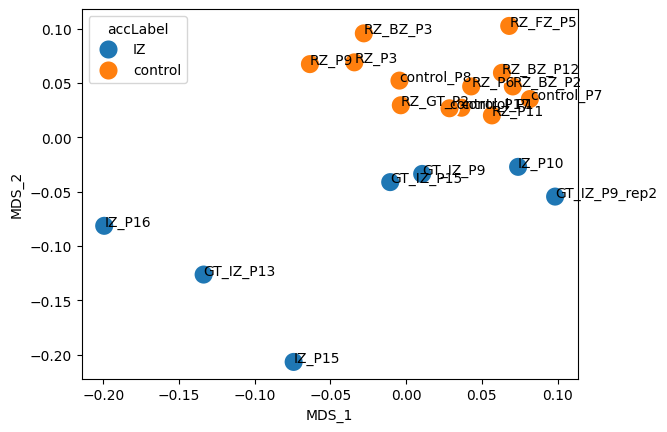

In [7]:
emb1 = manifold.MDS(dissimilarity='precomputed',random_state=42)
emb1 = emb1.fit_transform(eux)
sns.scatterplot(x=emb1[0:-2,0],
                y=emb1[0:-2,1],hue=labels,s=200)
for i in enumerate(labels.index):
    plt.text(x=emb1[i[0],0],
                    y=emb1[i[0],1],s=i[1])
    
plt.xlabel("MDS_1")
plt.ylabel("MDS_2")

In [8]:
aux=Aaccdt.p.T

In [9]:
Aaccdt.p['name']=[i.split('$')[0] for i in Aaccdt.p.index]

Text(0.5, 1.0, 'K-Barycenters')

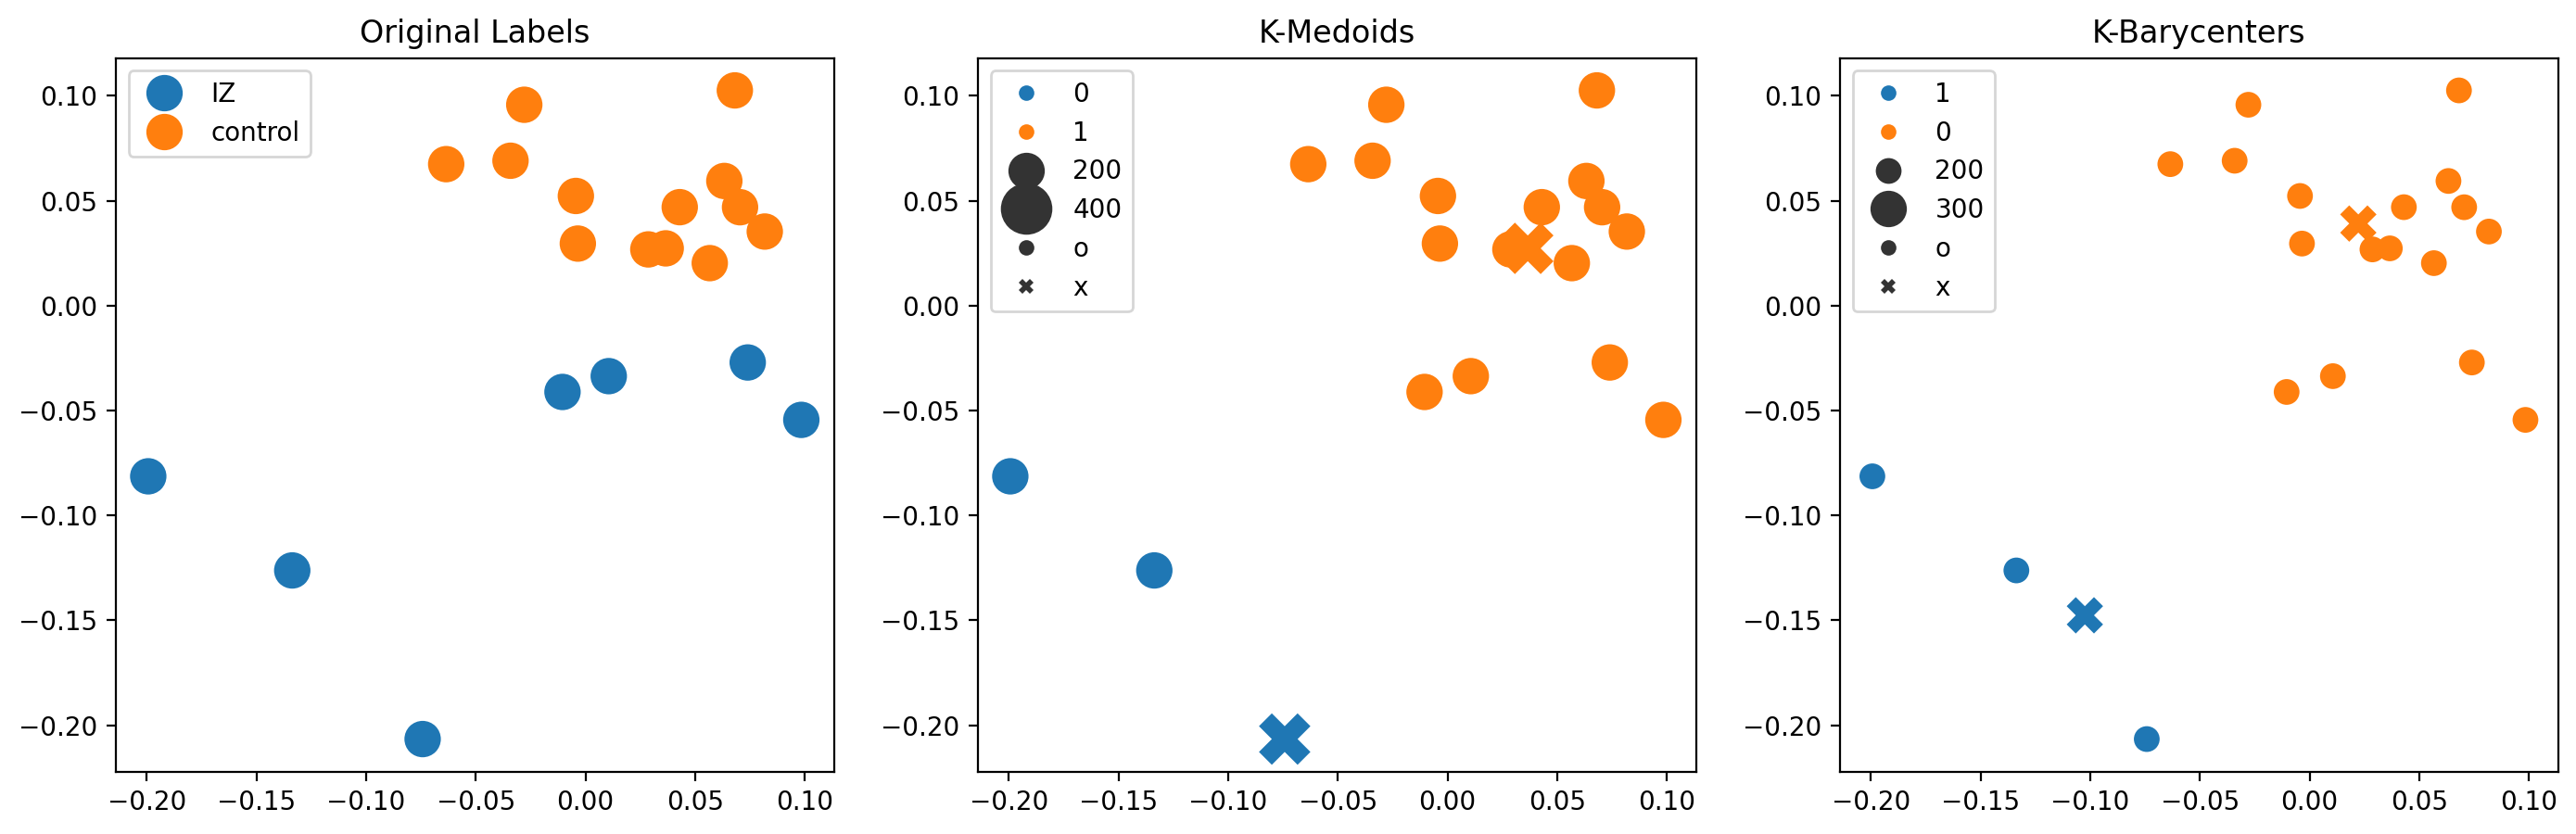

In [10]:
f1,axf1 = plt.subplots(1,3,figsize=(17,5),dpi=200)
axf1= axf1.ravel()
sns.scatterplot(x=emb1[0:len(labels),0],
                y=emb1[0:len(labels),1],hue=labels,s=200,ax=axf1[0],linewidth=0)
axf1[0].set_title('Original Labels')
axf1[0].legend(loc=0)
currlab=c.labels_.tolist()
currlab[c.medoid_indices_[0]] = 0
currlab[c.medoid_indices_[1]] = 1
currmark = ['o']*len(labels)
currmark[c.medoid_indices_[0]] = 'x'
currmark[c.medoid_indices_[1]] = "x"
currs =[200]*len(labels)
currs[c.medoid_indices_[0]] = 400
currs[c.medoid_indices_[1]] = 400

sns.scatterplot(x=emb1[0:len(labels),0],
                y=emb1[0:len(labels),1],hue=currlab,ax=axf1[1],style=currmark,
                size=currs,sizes=(200,400),linewidth=0) 
axf1[1].legend(loc=0)

axf1[1].set_title('K-Medoids')
tmplab = ncls.flabels.tolist()
for i in [0,1]:
    tmplab.append(i) 
currmark = ['o' if i<len(labels) else 'x' for i in range(len(tmplab))]
currs = [200 if i<len(labels) else 300 for i in range(len(tmplab))]
sns.scatterplot(x=emb1[:,0],
                y=emb1[:,1],hue=tmplab,ax=axf1[2],style=currmark,
                size=currs,sizes=(100,200),linewidth=0,hue_order=[1,0])
axf1[2].legend(loc=0)
axf1[2].set_title('K-Barycenters')
#f1.savefig("MedoidsBarycenterMI.pdf")

In [11]:
Aaccdt.p.iloc[:,c.medoid_indices_[0]][np.isinf(Aaccdt.p.iloc[:,c.medoid_indices_[0]])]

Series([], Name: IZ_P15, dtype: float64)

In [12]:
cls1 = pd.DataFrame({"Medoid1":np.round(Aaccdt.p.iloc[:,c.medoid_indices_[0]]/
                                          Aaccdt.p.iloc[:,c.medoid_indices_[0]].sum(),5),
            "Barycenter2":ncls.bary[1]})

In [13]:
cls1['name'] = [i.replace('$','->') for i in cls1.index]
cls1.set_index('name',inplace=True)

In [14]:
cls1['diff'] = cls1['Barycenter2']-cls1['Medoid1']

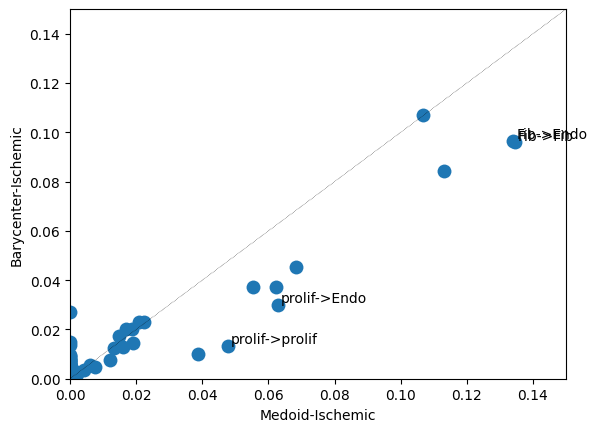

In [38]:
import statsmodels.api as sm
model = sm.OLS(cls1.Medoid1, cls1.Barycenter2)
cls1['resid'] = model.fit().resid
g = sns.scatterplot(x="Medoid1",y="Barycenter2", data=cls1,s=100,linewidth=0)
#indices to annotat
head = cls1.sort_values('diff').head(4)

tail = cls1.sort_values('diff').tail(4)
sns.lineplot(x=np.linspace(0,0.15),
             y=np.linspace(0,0.15),c='black',linestyle='dotted',linewidth=0.4)
stdev = cls1['Barycenter2'].std()/2

#sns.1lineplot(x=np.linspace(0,cls1['Medoid1'].max()),
#             y=np.linspace(0+stdev,cls1['Barycenter2'].max()+stdev),c='red',linestyle='dotted')


#sns.lineplot(x=np.linspace(0,cls1['Medoid1'].max()),
#             y=np.linspace(0-stdev,
#                           cls1['Barycenter2'].max()-stdev),c='red',linestyle='dotted')

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=(r["Medoid1"], r["Barycenter2"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
#for row in tail.iterrows():
#    ann(row)
plt.xlim(0,0.15)
plt.ylim(0,0.15)
plt.xlabel("Medoid-Ischemic")
plt.ylabel("Barycenter-Ischemic")
plt.savefig('CompMedBary1.pdf')

In [16]:
aux['clsmedoids'] = km.labels_
aux['clsbary'] = ncls.flabels


In [28]:
y=aux.iloc[c.medoid_indices_[0],:]
msemed = {}
for i in aux.loc[aux.clsmedoids==0,:].index:
    #if i != y.name:
    msemed[i]=np.abs(y/y.sum()-(aux.loc[i,:][:-2]/aux.loc[i,:][:-2].sum()))
y=ncls.bary[1]
msebary = {}
for i in aux.loc[aux.clsbary==1,:].index:
    msebary[i]=np.abs(y-(aux.loc[i,:][:-2]/aux.loc[i,:][:-2].sum()))


In [29]:
sel=[
 *head.index.to_list()]#,*head.index.to_list()]

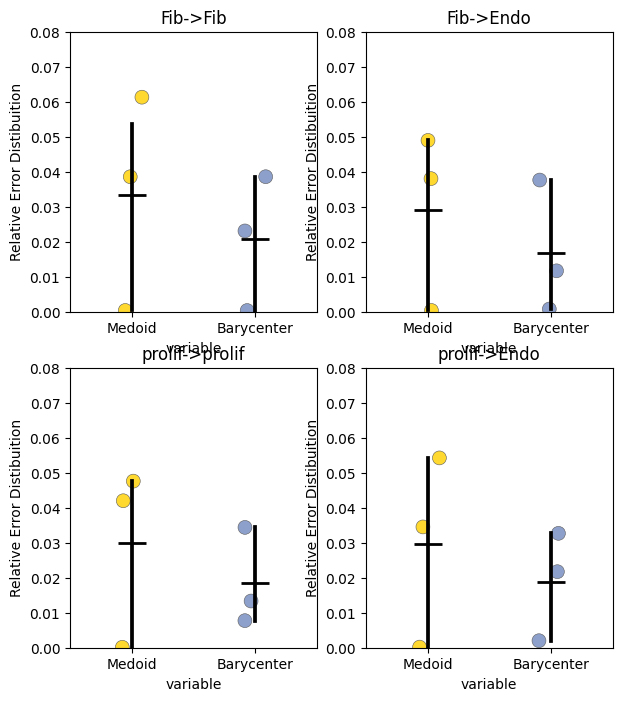

In [44]:
f,axs = plt.subplots(2,2,figsize=(7,8))
axs = axs.ravel()
cnt=0
for i in sel:
    i = i.replace("->","$")
    einter1 = pd.concat([pd.DataFrame.from_dict(msemed).T[i],
                                      pd.DataFrame.from_dict(msebary).T[i]],axis=1)
    einter1.columns =['Medoid','Barycenter']
    sns.stripplot(x='variable',y='value',hue='variable',data=einter1.round(5).reset_index().melt(id_vars='index'),
               palette='Set2_r',ax=axs[cnt],zorder=1,s=10,linewidth=0.4)
    sns.pointplot(x='variable',y='value',
                  data=einter1.round(5).reset_index().melt(id_vars='index'),linestyle="none",
                  ci=95,ax=axs[cnt],color='black', 
                  marker="_", markersize=20, markeredgewidth=2,)
    axs[cnt].set_title(i.replace('$','->'))
    axs[cnt].set_ylabel('Relative Error Distibuition')
    axs[cnt].set_ylim(-0.000005,0.08)
    cnt+=1
plt.savefig("medoidsdiff.pdf")

In [31]:
dtall = pd.concat([pd.DataFrame(msemed).mean(axis=1),
                   pd.DataFrame(msebary).mean(axis=1)],axis=1)

In [32]:
dtall = dtall.loc[aux.columns[:-2],:]

<AxesSubplot: xlabel='variable', ylabel='value'>

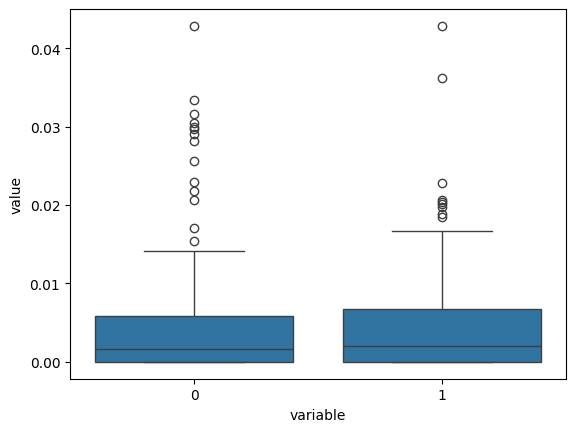

In [33]:
sns.boxplot(y="value",x='variable',data=dtall.reset_index().melt(id_vars='index'))

In [34]:
import scipy.stats as sts

In [37]:
sts.ranksums(x=dtall[0],y=dtall[1],alternative='less')

RanksumsResult(statistic=-2.335169880624426, pvalue=0.009767273953640973)